In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sympy
from sympy import Symbol, solve
from datetime import datetime
from numpy import pi, sin, cos, tan, arcsin, arccos, arctan, sqrt
from sklearn.preprocessing import MinMaxScaler
from skspatial.objects import Circle, Line
from numba import njit
import random

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
PHI = 39.4 / 180 * pi
ST = [9.0, 10.5, 12.0,  13.5, 15.0]
D = [(datetime(2023,i,21)-datetime(2023,3,21)).days for i in range(1, 13)]
h_t = 80 # 集热器中心高度
h_max = 84 # 塔顶端高度
h_m = 4  # 定日镜中心高度
m_length, m_width = 6, 6
m_x_bound, m_y_bound = [-3,3], [-3,3] # 定日镜坐标边界
t_x_bound, t_z_bound = [-3.5, 3.5], [0, h_max]

In [3]:
def cal_mod_length(x):
    return sqrt(x[0]**2+x[1]**2)

## 计算太阳高度角，方位角

In [4]:
def cal_omega(st):
    # 计算太阳时角
    return pi / 12 * (st - 12)

def cal_delta(d):
    # 计算太阳赤纬角
    sin_delta = sin(2*pi*d/365) * sin(2*pi*23.45/360)
    return arcsin(sin_delta)

def scale_in_min_max(num, min=-1, max=1):
    # 将结果限制在范围内
    if (num < min): return min
    elif (num > max): return max
    else: return num

def cal_alpha_and_gamma_s(d, st):
    # 计算太阳高度角和方位角
    omega = cal_omega(st)
    delta = cal_delta(d)
    sin_alpha_s = cos(delta)*cos(PHI)*cos(omega) + sin(delta)*sin(PHI)
    sin_alpha_s = scale_in_min_max(sin_alpha_s)
    alpha_s = arcsin(sin_alpha_s)
    cos_gamma_s = (sin(delta) - sin(alpha_s) * sin(PHI)) / ((cos(alpha_s) * cos(PHI)))
    cos_gamma_s = scale_in_min_max(cos_gamma_s)
    gamma_s = arccos(cos_gamma_s)
    if (st > 12): 
        gamma_s = 2*pi - gamma_s
    return alpha_s, gamma_s

In [5]:
alpha_mat = np.zeros((12, 5))
gamma_mat = np.zeros((12, 5))
for i, d in enumerate(D):
    for j, st in enumerate(ST):
        alpha, gamma = cal_alpha_and_gamma_s(d, st)
        alpha_mat[i,j] = alpha
        gamma_mat[i,j] = gamma

## 计算定日镜俯仰角，方位角

In [7]:
df = pd.read_excel("附件.xlsx")
mirrors_xy = df.values
mirrors_xyz = np.insert(mirrors_xy, 2, values=h_m, axis=1)

In [8]:
def cal_S_r(mirror_xyz):
    # 计算反射光线单位向量
    O = np.array([0 ,0, h_t])
    O_A = np.array(mirror_xyz)
    v = O - O_A
    v = v / np.linalg.norm(v)
    return v

In [9]:
def cal_S_i(alpha, gamma):
    # 计算入射光线单位向量
    # alpha, gamma是弧度制
    x = -cos(alpha) * cos(gamma-pi/2)
    y = cos(alpha) * sin(gamma-pi/2)
    z = -sin(alpha)
    return np.array([x, y, z])

In [10]:
# 计算定日镜法向量
S_i_mat = np.zeros((12, 5, 3))
S_r_mat = np.zeros((12, 5, *mirrors_xyz.shape))
S_n_mat = np.zeros((12, 5, *mirrors_xyz.shape))
for i, d in enumerate(D):
    for j, st in enumerate(ST):
        alpha, gamma = cal_alpha_and_gamma_s(d, st)
        S_i = cal_S_i(alpha, gamma)
        S_i_mat[i,j] = S_i
        for k, mirror_xyz in enumerate(mirrors_xyz):
            S_r = cal_S_r(mirror_xyz)
            S_n = (S_r - S_i) / np.linalg.norm(S_r - S_i)
            S_r_mat[i,j,k] = S_r
            S_n_mat[i,j,k] = S_n

In [11]:
def cal_theta(S_n):
    # 计算定日镜俯仰角，方位角
    # 俯仰角：[0, pi/2)
    # 方位角：[0, 2*pi)
    x, y, z = S_n
    theta_z = arctan(sqrt(x**2 + y**2) / z)
    if theta_z < 0:
        theta_z = theta_z + pi
    theta_s = arcsin(x / sqrt(x**2 + y**2))
    if x > 0 and y < 0:
        theta_s = pi - theta_s
    elif x <= 0 and y >= 0:
        theta_s = 2*pi + theta_s
    elif x <= 0 and y < 0:
        theta_s = pi - theta_s
    return theta_z, theta_s

In [12]:
# 计算定日镜俯仰角，方位角
theta_mat = np.zeros((12, 5, mirrors_xyz.shape[0], 2))
for i, d in enumerate(D):
    for j, st in enumerate(ST):
        alpha, gamma = cal_alpha_and_gamma_s(d, st)
        S_i = cal_S_i(alpha, gamma)
        for k, mirror_xyz in enumerate(mirrors_xyz):
            S_r = cal_S_r(mirror_xyz)
            S_n = (S_r - S_i) / np.linalg.norm(S_r - S_i)
            theta_z, theta_s = cal_theta(S_n)
            theta_mat[i,j,k] = [theta_z, theta_s]

## 计算简单效率

In [14]:
# 计算余弦效率
ita_cos_mat = np.zeros((12, 5, mirrors_xyz.shape[0]))
for i, d in enumerate(D):
    for j, st in enumerate(ST):
        alpha, gamma = cal_alpha_and_gamma_s(d, st)
        S_i = cal_S_i(alpha, gamma)
        neg_S_i = -S_i
        for k, mirror_xyz in enumerate(mirrors_xyz):
            ita_cos = S_n_mat[i,j,k] @ neg_S_i
            ita_cos_mat[i,j,k] = ita_cos 
            
print("年平均余弦效率:", ita_cos_mat.mean())
for i, d in enumerate(D):
    print(f"{i+1:2}月平均余弦效率:", ita_cos_mat[i].mean())

年平均余弦效率: 0.7564654978846909
 1月平均余弦效率: 0.719935764230188
 2月平均余弦效率: 0.7404403532037785
 3月平均余弦效率: 0.7611400153929363
 4月平均余弦效率: 0.7793399687370516
 5月平均余弦效率: 0.7893169789883199
 6月平均余弦效率: 0.7923588160987858
 7月平均余弦效率: 0.7892118485227697
 8月平均余弦效率: 0.77863694634725
 9月平均余弦效率: 0.7600919805120643
10月平均余弦效率: 0.7378354064925948
11月平均余弦效率: 0.7181956127447959
12月平均余弦效率: 0.7110822833457546


In [15]:
# 计算大气透射率
def cal_ita_at(mirror_xyz):
    d = np.linalg.norm(mirror_xyz - np.array([0, 0, h_t]))
    return 0.99321 - 0.0001176*d + 1.97*10**(-8)*d**2
ita_at_mat = np.zeros(mirrors_xyz.shape[0])
for i, mirror_xyz in enumerate(mirrors_xyz):
    ita_at_mat[i] = cal_ita_at(mirror_xyz)

## 计算阴影遮挡

In [16]:
# 计算旋转矩阵
def cal_rot_mat(theta_z, theta_s):
    # 根据俯仰角和方位角，计算旋转矩阵
    beta, gamma = theta_z, theta_s
    sb, cb, sg, cg = sin(beta), cos(beta), sin(gamma), cos(gamma)
    return np.array([[cb*cg, -sg, sb*cg],
                     [sg*cb, cg,  sb*sg],
                     [-sb,   0,   cb]])

rot_mats = np.zeros((12, 5, mirrors_xyz.shape[0], 3, 3))
for i, _ in enumerate(D):
    for j, _ in enumerate(ST):
        for k, _ in enumerate(mirrors_xyz):
            theta_z, theta_s = theta_mat[i,j,k]
            rot_mats[i,j,k] = cal_rot_mat(theta_z, theta_s)

In [17]:
def cal_distance(m1xy, m2xy):
    # 计算二维距离
    dis = np.linalg.norm(m1xy - m2xy)
    return dis

In [18]:
@njit
def in_bound(x, bound):
    # 判断点是否出了边界
    if (x < bound[0] or x > bound[1]):
        return False
    return True

In [19]:
@njit
def a_blocked_by_b(xy, V_0, day_id, st_id, a_id, b_id, shoot_in):
    m_x_bound, m_y_bound = [-3,3], [-3,3] # 定日镜坐标边界
    # shoot_in参数是指光为入射光还是为反射光，可取bool值
    # 后缀为0, a, b指地面坐标系, a镜坐标系, b镜坐标系
    h1_a = np.array([*xy, 0])
    O_a = mirrors_xyz[a_id]
    O_b = mirrors_xyz[b_id]
    if (O_a[:2] - O_b[:2]) @ V_0[:2] <= 0 and shoot_in:
        return False
    elif (O_a[:2] - O_b[:2]) @ V_0[:2] > 0 and not shoot_in:
        return False
    a_rot_mat = rot_mats[day_id, st_id, a_id]
    b_rot_mat = rot_mats[day_id, st_id, b_id]
    h1_0 = a_rot_mat @ h1_a + O_a
    h1_b = b_rot_mat.T @ (h1_0 - O_b)
    V_b = b_rot_mat.T @ (V_0)
    x2_b = h1_b[0] - V_b[0]*h1_b[2]/ V_b[2]
    y2_b = h1_b[1] - V_b[1]*h1_b[2]/ V_b[2]
    h2_b = np.array([x2_b, y2_b, 0])
    if in_bound(x2_b, m_x_bound) and in_bound(y2_b, m_y_bound):
        return True
    return False

In [20]:
@njit
def a_blocked_by_tower(xy, day_id, st_id, a_id):
    t_x_bound, t_z_bound = [-3.5, 3.5], [0, 84]
    # 后缀为0, a, t指地面坐标系, a镜坐标系, 塔坐标系
    h1_a = np.array([*xy, 0])
    O_a = mirrors_xyz[a_id]
    if (O_a[1] <= 0):
        return False
    a_rot_mat = rot_mats[day_id, st_id, a_id]
    h1_0 = a_rot_mat @ h1_a + O_a
    alpha, gamma = alpha_mat[day_id,st_id], gamma_mat[day_id,st_id]
    t_xy_rot_mat = np.array([[-cos(gamma), -sin(gamma)],
                             [sin(gamma), -cos(gamma)]])
    xy_t = t_xy_rot_mat @ h1_0[0:2]
    h1_t = np.array([*xy_t, h1_0[2]])
    if h1_t[1] >= 0:
        z_delta = tan(alpha)*sqrt(xy[0]**2 + xy[1]**2)
        z2_t = z_delta + h1_t[2]
        h2_t = np.array([h1_t[0], 0, z2_t]) # h2_t为射向h1点的光与塔平面的交点
        if t_x_bound[0] <=h2_t[0] <= t_x_bound[1] and t_z_bound[0] <= h2_t[2] <=t_z_bound[1]:
            return True
    return False

In [21]:
# 蒙特卡洛法，将定日镜等分成36个1m^2区域，每一个区域取中心点
x_mont = [-2.5, -1.5, -0.5, 0.5, 1.5, 2.5]
y_mont = [-2.5, -1.5, -0.5, 0.5, 1.5, 2.5]
xy_mont = np.array([[x, y] for x in x_mont for y in y_mont])

In [22]:
# 取每面定日镜的最近邻8面镜子，判断是否发生阴影或遮挡
MAX_NEAR_NUM = 8
near_mat = np.zeros((mirrors_xyz.shape[0], MAX_NEAR_NUM), dtype=np.int64)
for a_id, m1xy in enumerate(mirrors_xy):
    # 计算和其他镜子的距离
    distances = {}
    for b_id, m2xy in enumerate(mirrors_xy):
        if a_id == b_id:
            continue
        distances[b_id] = cal_distance(m1xy, m2xy)
    # 排序取出最近邻的8面镜子
    ls = []
    for new_b_id, _ in sorted(distances.items(), key = lambda kv:(kv[1], kv[0]))[:MAX_NEAR_NUM]:
        ls.append(new_b_id)
    near_mat[a_id] = ls

11.680917301308147
11.680917301308147
11.681732748184231
11.68050688112464
11.68050688112464
11.68106386422059
11.68106386422059
11.68084594539282
11.68084594539282
11.680948805640742
11.6805676659998
11.6805676659998
11.680484279343899
11.680484279343899
11.680484279343899
11.680484279343899
11.6805676659998
11.6805676659998
11.680948805640742
11.68084594539282
11.68084594539282
11.68106386422059
11.68106386422059
11.68050688112464
11.68050688112464
11.681732748184231
11.680917301308147
11.680917301308147
11.681109536341143
11.680917301308147
11.680917301308147
11.681732748184231
11.68050688112464
11.68050688112464
11.68106386422059
11.68106386422059
11.68084594539282
11.68084594539282
11.680948805640742
11.6805676659998
11.6805676659998
11.680484279343899
11.680484279343899
11.680484279343899
11.680484279343899
11.6805676659998
11.6805676659998
11.680948805640742
11.68084594539282
11.68084594539282
11.68106386422059
11.68106386422059
11.68050688112464
11.68050688112464
11.68173274818

In [ ]:
# 计算塔平面产生的阴影
blocked_mat = np.zeros((12, 5, mirrors_xyz.shape[0], len(x_mont), len(y_mont)), dtype=bool)
for i, d in enumerate(D):
    for j, st in enumerate(ST):
        for a_id, _ in enumerate(mirrors_xyz):
            for x_id, x in enumerate(x_mont):
                for y_id, y in enumerate(y_mont):
                    if a_blocked_by_tower([x,y], i, j, a_id):
                        # 被塔挡住，产生阴影
                        blocked_mat[i, j, a_id, x_id, y_id] = True

# 计算定光镜相互阴影
for i, d in enumerate(D):
    for j, st in enumerate(ST):
        S_i = S_i_mat[i, j]
        for a_id, near_pairs in enumerate(near_mat):
            for b_id in near_pairs:
                for x_id, x in enumerate(x_mont):
                    for y_id, y in enumerate(y_mont):
                        if a_blocked_by_b([x,y], S_i, i, j, a_id, b_id, shoot_in=True):
                            # 把入射光挡住，产生阴影
                            blocked_mat[i, j, a_id, x_id, y_id] = True

# 计算遮挡
for i, d in enumerate(D):
    for j, st in enumerate(ST):
        for a_id, near_pairs in enumerate(near_mat):
            S_r = S_r_mat[i,j,a_id]
            for b_id in near_pairs:
                for x_id, x in enumerate(x_mont):
                    for y_id, y in enumerate(y_mont):
                        if (not blocked_mat[i, j, a_id, x_id, y_id]) and \
                        a_blocked_by_b([x,y], S_r, i, j, a_id, b_id, shoot_in=False):
                            # 没有阴影，并且反射光被挡住
                            blocked_mat[i, j, a_id, x_id, y_id] = True

In [27]:
ita_sb_mat = np.zeros((12, 5, mirrors_xyz.shape[0]))
for i, _ in enumerate(D):
    for j, _ in enumerate(ST):
        for k, _ in enumerate(mirrors_xyz):
            ita_sb_mat[i,j,k] = 1 - blocked_mat[i,j,k].sum() / (len(x_mont)*len(y_mont)) 

print("年平均阴影遮挡效率", ita_sb_mat.mean())
for i, _ in enumerate(D):
    print(f"{i+1:2}月平均阴影遮挡效率:", ita_sb_mat[i].mean())

年平均阴影遮挡效率 0.9570423432028016
 1月平均阴影遮挡效率: 0.9411620503024515
 2月平均阴影遮挡效率: 0.9563737663164598
 3月平均阴影遮挡效率: 0.9626870423432027
 4月平均阴影遮挡效率: 0.9668258516396053
 5月平均阴影遮挡效率: 0.9694333014963389
 6月平均阴影遮挡效率: 0.9703024514485832
 7月平均阴影遮挡效率: 0.9694333014963387
 8月平均阴影遮挡效率: 0.9661986628462271
 9月平均阴影遮挡效率: 0.9624864692773003
10月平均阴影遮挡效率: 0.9547596306908629
11月平均阴影遮挡效率: 0.9391435848455906
12月平均阴影遮挡效率: 0.925702005730659


## 计算截断效率

In [29]:
MAX_ANGLE = 4.65 * 10**(-3)
angle_divide_num = 3
circle_divide_num = 6
tao_arr = np.linspace(0, 2*pi, circle_divide_num, endpoint=False)
sigma_arr = np.linspace(MAX_ANGLE, 0, angle_divide_num, endpoint=False)
light_mat = np.zeros((len(tao_arr) * len(sigma_arr), 3))
for i, tao in enumerate(tao_arr):
    for j, sigma in enumerate(sigma_arr):
        light_mat[len(sigma_arr)*i+j] = [sin(sigma)*cos(tao), sin(sigma)*sin(tao), cos(sigma)]

In [30]:
light_rot_mats = np.zeros((12, 5, mirrors_xyz.shape[0], 3, 3))
for i, d in enumerate(D):
    for j, st in enumerate(ST):
        for k, _ in enumerate(mirrors_xyz):
            S_r = S_r_mat[i,j,k]
            if (S_r[1] == 0):
                theta_x = pi / 2
            else:
                theta_x = arctan(-S_r[0] / S_r[1])
            x_s = np.array((cos(theta_x), sin(theta_x), 0))
            y_s = np.cross(S_r, x_s)
            # y_s = y_s / np.linalg.norm(y_s)
            light_rot_mats[i,j,k] = np.array((x_s, y_s, S_r)).T

In [31]:
R = 3.5
r_bound = [-3.5, 3.5]
machine_bound = [76, 84]
circle = Circle([0, 0], R)

def light_meet_machine(xy, light_0, day_id, st_id, m_id):
    m, n, l = light_0
    h1_a = np.array([*xy, 0])
    O_a = mirrors_xyz[a_id]
    rot_mat = rot_mats[day_id, st_id, a_id]
    h1_0 = rot_mat @ h1_a + O_a
    x1, y1, z1 = h1_0
    if (abs(m*y1 - n*x1) / sqrt(n**2+m**2) < R):
        line = Line([x1, y1], [x1+m, y1+n])
        point_a, point_b = circle.intersect_line(line)
        if abs(x1) < abs(y1):
            z = min(l*(point_a[1]-y1)/n+z1, l*(point_b[1]-y1)/n+z1)
        else:
            z = min(l*(point_a[0]-x1)/m+z1, l*(point_b[0]-x1)/m+z1)
        if in_bound(z, machine_bound):
            return True
    return False

In [32]:
trunc_mat = np.zeros((12, 5, mirrors_xyz.shape[0], len(x_mont), len(y_mont)))
for i, d in enumerate(D):
    for j, st in enumerate(ST):
        for k, mirror_xyz in enumerate(mirrors_xyz):
            for l_id, light in enumerate(light_mat):
                light_0 = light_rot_mats[i,j,k] @ light
                for x_id, x in enumerate(x_mont):
                     for y_id, y in enumerate(y_mont):
                        trunc_mat[i,j,k,x_id,y_id] = angle_divide_num * circle_divide_num
                        if blocked_mat[i,j,k,x_id,y_id]:
                            trunc_mat[i,j,k,x_id,y_id] = 0
                        if not blocked_mat[i,j,k,x_id,y_id] and \
                        not light_meet_machine([x,y], light_0, i, j, k):
                            trunc_mat[i,j,k,x_id,y_id] -= 1

/home/crw/.mambaforge/lib/python3.10/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'bound' of function 'in_bound'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../tmp/ipykernel_21014/2962963315.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [33]:
ita_trunc_mat = np.zeros((12, 5, mirrors_xyz.shape[0]))
for i, d in enumerate(D):
    for j, st in enumerate(ST):
        for k, mirror_xyz in enumerate(mirrors_xyz):
            cnt = 0
            for x_id, x in enumerate(x_mont):
                 for y_id, y in enumerate(y_mont):
                    if not blocked_mat[i,j,k,x_id,y_id]:
                        cnt += 1
            if cnt == 0:
                ita_trunc_mat[i,j,k] = 0.94444444 # 对全阴影镜赋均值
            else:
                ita_trunc_mat[i,j,k] = trunc_mat[i,j,k].sum() / cnt / (angle_divide_num * circle_divide_num)

In [34]:
print("年平均截断效率:", ita_trunc_mat.mean())
for i, _ in enumerate(D):
    print(f"{i+1:2}月平均截断效率:", ita_trunc_mat[i].mean())

年平均截断效率: 0.9444783085251821
 1月平均截断效率: 0.944479673214254
 2月平均截断效率: 0.9444789345112174
 3月平均截断效率: 0.9444776964119851
 4月平均截断效率: 0.944477342665563
 5月平均截断效率: 0.9444773426670914
 6月平均截断效率: 0.9444773426670914
 7月平均截断效率: 0.9444773426665819
 8月平均截断效率: 0.9444773426650537
 9月平均截断效率: 0.9444780501553506
10月平均截断效率: 0.9444791113834095
11月平均截断效率: 0.9444796732117069
12月平均截断效率: 0.9444798500828803


## 计算DNI

In [36]:
G0 = 1.366
H = 3
a = 0.4237 - 0.00821*(6-H)**2
b = 0.5055 + 0.00595*(6.5-H)**2
c = 0.2711 + 0.01858*(2.5-H)**2
DNI_mat = np.zeros((12, 5))
for i, _ in enumerate(D):
    for j, _ in enumerate(ST):
        alpha, gamma = cal_alpha_and_gamma_s(D[i], ST[j])
        DNI_mat[i,j] = G0*(a + b*pow(np.e,-c/sin(alpha)))

## 计算光学效率

In [38]:
ita_ref = 0.92
ita_mat = np.zeros((12, 5, mirrors_xyz.shape[0]))
for i, _ in enumerate(D):
    for j, _ in enumerate(ST):
        for k, _ in enumerate(mirrors_xyz):
            ita_cos = ita_cos_mat[i,j,k]
            ita_at = ita_at_mat[i]
            ita_sb = ita_sb_mat[i,j,k]
            ita_trunc = ita_trunc_mat[i,j,k]
            ita_mat[i,j,k] = ita_cos * ita_sb * ita_at * ita_ref * ita_trunc

In [39]:
print("年平均光学效率:", ita_mat.mean())
for i, _ in enumerate(D):
    print(f"{i+1:2}月平均光学效率:", ita_mat[i].mean())

年平均光学效率: 0.6128539209227929
 1月平均光学效率: 0.5705788308580515
 2月平均光学效率: 0.5985741249213797
 3月平均光学效率: 0.6204938379536719
 4月平均光学效率: 0.6391687773691623
 5月平均光学效率: 0.6497484448664954
 6月平均光学效率: 0.6530072646178139
 7月平均光学效率: 0.6496548105435068
 8月平均光学效率: 0.6381186928205955
 9月平均光学效率: 0.6194489681017177
10月平均光学效率: 0.5952324139689419
11月平均光学效率: 0.5677626694921472
12月平均光学效率: 0.5524582155600312


## 计算热功率

In [40]:
E_mat = np.zeros((12, 5, mirrors_xyz.shape[0]))
for i, _ in enumerate(D):
    for j, _ in enumerate(ST):
        for k, _ in enumerate(mirrors_xyz):
            E_mat[i,j,k] = DNI_mat[i,j] * m_length * m_width * ita_mat[i,j,k]

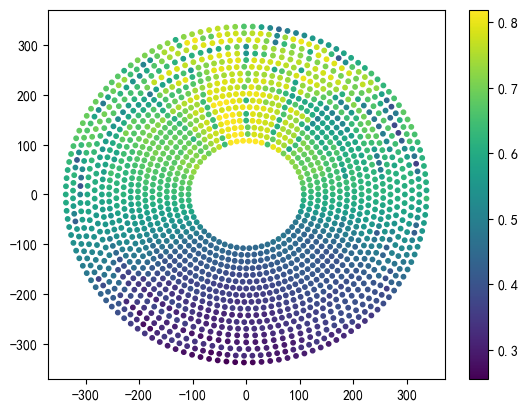

In [41]:
cm = matplotlib.colormaps['viridis']
sc = plt.scatter(mirrors_xy[:,0], mirrors_xy[:,1], c=ita_mat[i].mean(axis=0), s=10, cmap=cm)
plt.colorbar(sc)
plt.show()

In [42]:
print("年单位面积镜面平均输出热功率:", E_mat.mean() / 36)
for i, _ in enumerate(D):
    print(f"{i+1:2}月单位面积镜面平均输出热功率:", E_mat[i].mean() / 36)

年单位面积镜面平均输出热功率: 0.5964807095650042
 1月单位面积镜面平均输出热功率: 0.4973536047410204
 2月单位面积镜面平均输出热功率: 0.5644424640300109
 3月单位面积镜面平均输出热功率: 0.6172715029661683
 4月单位面积镜面平均输出热功率: 0.6578343718260125
 5月单位面积镜面平均输出热功率: 0.6789145748433975
 6月单位面积镜面平均输出热功率: 0.6852069432985224
 7月单位面积镜面平均输出热功率: 0.6787156157640047
 8月单位面积镜面平均输出热功率: 0.6559983078597027
 9月单位面积镜面平均输出热功率: 0.61483078600936
10月单位面积镜面平均输出热功率: 0.5566626952988053
11月单位面积镜面平均输出热功率: 0.49071990501076473
12月单位面积镜面平均输出热功率: 0.4598177431322814


In [43]:
print("年平均输出热功率:", (E_mat.sum() / 5 / 12))
for i, _ in enumerate(D):
    print(f"{i+1:2}月平均输出热功率(kW):", E_mat[i].sum() / 5)

年平均输出热功率: 37470.918174873565
 1月平均输出热功率(kW): 31243.753449830903
 2月平均输出热功率(kW): 35458.27559036528
 3月平均输出热功率(kW): 38776.99581633469
 4月平均输出热功率(kW): 41325.15523811011
 5月平均输出热功率(kW): 42649.41359166223
 6月平均输出热功率(kW): 43044.70017801317
 7月平均输出热功率(kW): 42636.91498229477
 8月平均输出热功率(kW): 41209.81369974652
 9月平均输出热功率(kW): 38623.669977108
10月平均输出热功率(kW): 34969.55051867095
11月平均输出热功率(kW): 30827.02443277624
12月平均输出热功率(kW): 28885.75062356992
